# Library

In [102]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle


# Dataset

In [103]:
# Read dataset
data = pd.read_csv('clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threaten suiciderec left wife good che...
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affect compliment come someon know i...
2,Finally 2020 is almost over... So I can never ...,non-suicide,final almost never hear bad year ever swear fu...
3,i need helpjust help me im crying so hard,suicide,need helpjust help im cri hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggl year afraid past y...


# Encoding

In [104]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

# Test Train Split

In [105]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, test_size=.2, random_state=42)

# Data Preprocessing

In [106]:
vocab_size = 10_000
max_length = 10_000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [107]:
# Save the word index dictionary
np.save('word_index.npy', word_index)

# Save Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Basic Model Embeding Layers

In [108]:
embedding_dim = 16

# Initialize the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Basic_Model_Embedding_Layers.keras", 
                                       save_best_only=True, 
                                       monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1)


# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [110]:
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_max_length(texts, percentile=95):
    # Tokenize the texts
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Get the lengths of the sequences
    sequence_lengths = [len(seq) for seq in sequences]
    
    # Calculate the percentile length
    max_length = int(np.percentile(sequence_lengths, percentile))

    
    print(f"Recommended max_length (based on {percentile}th percentile): {max_length}")
    return max_length

# Example usage
texts = ["ex wife threaten suiciderec left wife good cheat twice lie much decid refus go back day ago began threaten suicid tirelessli spent paat day talk keep hesit want believ come back know lot peopl threaten order get way happen realli suppos handl death hand still love wife cannot deal get cheat constantli feel insecur worri today may day hope much happen","weird get affect compliment come someon know irl feel realli good internet stranger","losthello name adam struggl year afraid past year thought suicid fear anxieti close limit quiet long scare come famili feel year ago lose aunt trigger everyday feel hopeless lost guilti remors thing done life thought like littl experienc life time reveal feel famili broke saw cut watch get worri someth portray averag day made feel absolut dread later found attempt survivor attempt od overdos pill attempt hang happen blackout pill never went noos still afraid first therapi diagnos sever depress social anxieti eat disord later transfer fucken group therapi reason made feel anxiou eventu last session therapi show result daili check feel step survey mom dad come find put feel horribl afraid anxiou everyday mom absolut amaz describ happiest ever seen therapi help eventu put sertalin anti anxieti anti depress sorri forgot never finish first prescript ever found right type anti depress mom thought want drug took recommend pill schedul week stop take time feel wors afraid damag worri caus even everyth go afraid ever relaps cut develop sever insomnia day day feel hopeless worthless question still motiv move bed keep go ask nearli everi night almost break everytim pleas pleas pleas someon anyon help scare might someth drastic shape fear anxieti idk anymore","fuck verizon smart famili app even watch porn privat anymor wtf feature","think today may last everyth becom overwhelm late enough night think would enough go final end miser life mine plan work certain friend call know abl actual move know want anymor die fix everyth like pain chest everyth els die would fix everyth stop nuisanc past peopl care wast anyon time dead amp think time right go","nice song lt nice song vibe loverboy wall come true khai dream weak ur around blackbear need khai dream carwash stripteas slow pleas listen"]
max_length = find_optimal_max_length(texts, percentile=95)


Recommended max_length (based on 95th percentile): 168


In [111]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Reduce padding length to a reasonable maximum length (e.g., 200)
max_length = 180
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating='post')
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to NumPy arrays (if not already)
training_labels = np.array(training_labels).flatten()
testing_labels = np.array(testing_labels).flatten()

# Define the number of epochs and batch size
num_epochs = 15
batch_size = 32

# Define the model
vocab_size = 20000  # Set to your vocabulary size
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),  # Ensure input_length matches max_length (200)
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath="best_model.keras", 
                                       save_best_only=True, 
                                       monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_accuracy", 
                                        mode="max", 
                                        patience=3, 
                                        verbose=1, 
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", 
                                       factor=0.1, 
                                       patience=2, 
                                       verbose=1, 
                                       mode="min", 
                                       min_delta=0.0001, 
                                       min_lr=1e-6)

callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

# Train the model
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    callbacks=callbacks, 
                    batch_size=batch_size)


Epoch 1/15
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7483 - loss: 0.4494
Epoch 1: val_accuracy improved from -inf to 0.93918, saving model to best_model.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 229s 39ms/step - accuracy: 0.7483 - loss: 0.4494 - val_accuracy: 0.9392 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 2/15
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9442 - loss: 0.1522
Epoch 2: val_accuracy improved from 0.93918 to 0.94491, saving model to best_model.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 223s 38ms/step - accuracy: 0.9442 - loss: 0.1522 - val_accuracy: 0.9449 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 3/15
5801/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9554 - loss: 0.1204
Epoch 3: val_accuracy improved from 0.94491 to 0.94603, saving model to best_model.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 228s 39ms/step - accuracy: 0.9554 - loss: 0.1204 - val_accuracy: 0.9460 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 4/15
5802/5802 ━━━━━━━━━━

In [112]:
# Evaluate the model on the testing set
results = model.evaluate(testing_padded, testing_labels)

# Print the evaluation results (Loss and Accuracy)
print(f'Test results - Loss: {results[0]} - Accuracy: {100 * results[1]}%')


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9484 - loss: 0.1415
Test results - Loss: 0.14272059500217438 - Accuracy: 94.7624683380127%


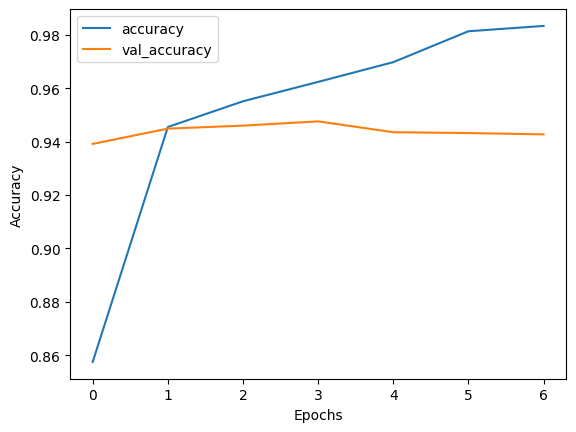

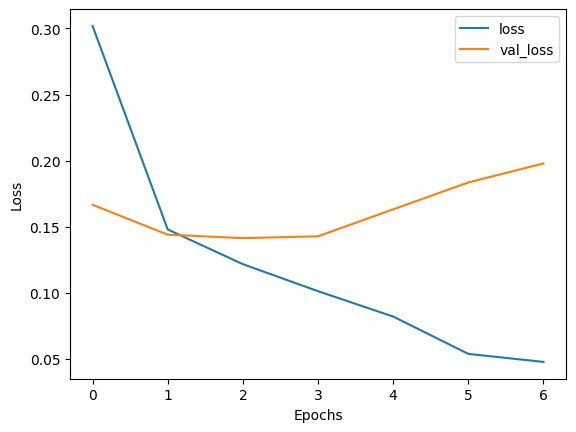

In [113]:
import matplotlib.pyplot as plt

# Plot utility function to plot accuracy and loss
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# Plot Accuracy and Loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [114]:
# Make predictions on the test data
predictions = model.predict(testing_padded)

# Convert predictions to binary values (0 or 1)
predicted_labels = (predictions > 0.5).astype("int32")

# Print the first few predictions and the actual labels for comparison
print(f"Predictions: {predicted_labels[:10]}")
print(f"Actual Labels: {testing_labels[:10]}")


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step
Predictions: [[1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]]
Actual Labels: [1 0 0 1 0 0 0 0 0 1]


# Model Basic + Global Average Pooling

In [115]:
embedding_dim = 16

# Initialize the model
model_GlobalAveragePooling1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_GlobalAveragePooling1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_GlobalAveragePooling1D.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Define the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Model_Basic_GAP.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [117]:
num_epochs = 55

# Train the model
history_GlobalAveragePooling1D = model_GlobalAveragePooling1D.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/55
5787/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.3204
Epoch 1: val_accuracy improved from -inf to 0.92627, saving model to Model_Basic_GAP.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8627 - loss: 0.3202 - val_accuracy: 0.9263 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 2/55
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9226 - loss: 0.2017
Epoch 2: val_accuracy did not improve from 0.92627
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9226 - loss: 0.2017 - val_accuracy: 0.9176 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 3/55
5801/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9294 - loss: 0.1843
Epoch 3: val_accuracy improved from 0.92627 to 0.93241, saving model to Model_Basic_GAP.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9294 - loss: 0.1843 - val_accuracy: 0.9324 - val_loss: 0.1845 - learning_rate: 0.0010
Epoch 4/55
5774/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.93

In [118]:
print(history_GlobalAveragePooling1D.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [119]:
# Evaluate the model
results_GlobalAveragePooling1D = model_GlobalAveragePooling1D.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_GlobalAveragePooling1D[0]} - Accuracy: {100*results_GlobalAveragePooling1D[1]}%')

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9380 - loss: 0.2048
Test results - Loss: 0.20806433260440826 - Accuracy: 93.78002882003784%


In [120]:
# After training
print(history_GlobalAveragePooling1D.history)


{'accuracy': [0.896374523639679, 0.9227023720741272, 0.9302377104759216, 0.9346113204956055, 0.9362918138504028, 0.9384947419166565, 0.9407516121864319, 0.9417749643325806, 0.9432238936424255, 0.9438433051109314, 0.9542494416236877, 0.9551489353179932, 0.9558491706848145, 0.9558438062667847, 0.9567701816558838, 0.9581329226493835, 0.9581275582313538, 0.9582783579826355, 0.9583376049995422, 0.9582191109657288, 0.9583860635757446, 0.9583591222763062, 0.9583214521408081, 0.9583752751350403, 0.9583537578582764, 0.9583591222763062, 0.9583752751350403, 0.9583376049995422, 0.9583537578582764, 0.958342969417572, 0.9583483934402466, 0.9583483934402466], 'loss': [0.25875553488731384, 0.20105570554733276, 0.18321596086025238, 0.17241506278514862, 0.1658036857843399, 0.16011881828308105, 0.15341109037399292, 0.1503329575061798, 0.14665991067886353, 0.14426487684249878, 0.11727769672870636, 0.11525199562311172, 0.11386147141456604, 0.11295441538095474, 0.11163751780986786, 0.10820557177066803, 0.10

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


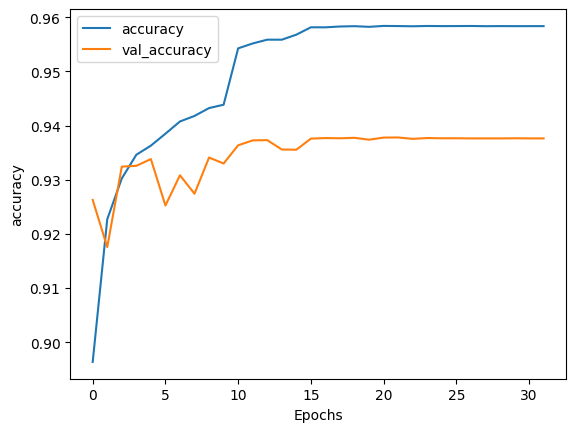

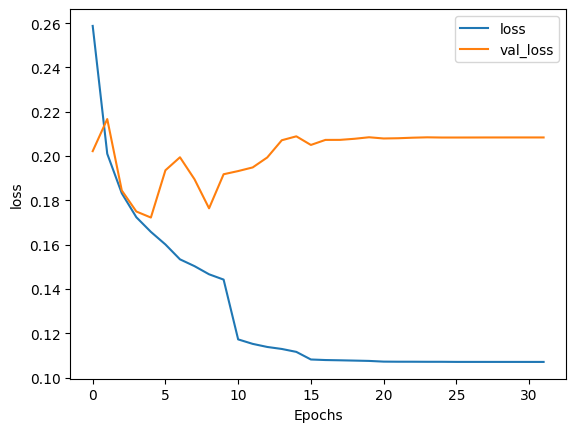

In [121]:
# Check the keys in the history to ensure you use the right ones
print(history_GlobalAveragePooling1D.history.keys())

# Plot utility
def plot_graphs(history, metric):
    # Check if 'val_' is in the history
    if f'val_{metric}' in history.history:
        plt.plot(history.history[metric])
        plt.plot(history.history[f'val_{metric}'])
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, f'val_{metric}'])
        plt.show()
    else:
        print(f"Validation metric {metric} not found in history.")

# Plot the accuracy and loss
plot_graphs(history_GlobalAveragePooling1D, "accuracy")  # Adjust the name if it's different
plot_graphs(history_GlobalAveragePooling1D, "loss")  # Adjust the name if it's different


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
                                                Text Predicted Label
0  I'm feeling hopeless and lost. Nothing seems t...        Positive
1  Today was a good day, and I managed to complet...        Positive
2  I feel anxious about tomorrow's meeting. I hop...        Positive
3  Sometimes I just want to disappear. The pressu...        Negative
4  Had a great time with friends today, felt genu...        Positive
5  I can't handle this stress anymore. It feels l...        Positive
6  Looking forward to starting a new hobby. It mi...        Negative
7  I hate myself. Every little thing I do seems t...        Negative
8  Life has been tough, but I'm trying to stay st...        Negative
9  I don't know how much longer I can keep preten...        Positive


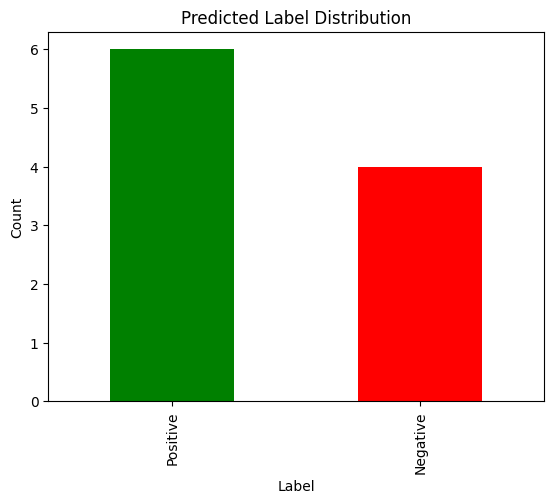

In [142]:
import numpy as np
from tensorflow.keras.models import load_model  # Use tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer  # Use tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Use tensorflow.keras
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained model (adjust path as necessary)
model = load_model("Model_Basic_GAP.keras")

# Real-world data (example)
real_data_text = [
    "I'm feeling hopeless and lost. Nothing seems to matter anymore.",
    "Today was a good day, and I managed to complete everything on my to-do list.",
    "I feel anxious about tomorrow's meeting. I hope it goes well.",
    "Sometimes I just want to disappear. The pressure is too much to handle.",
    "Had a great time with friends today, felt genuinely happy for the first time in a while.",
    "I can't handle this stress anymore. It feels like there's no way out.",
    "Looking forward to starting a new hobby. It might help me feel better.",
    "I hate myself. Every little thing I do seems to go wrong.",
    "Life has been tough, but I'm trying to stay strong and positive.",
    "I don't know how much longer I can keep pretending everything is fine."
]


# Tokenizer (fit it on real data, or load the one used during training)
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(real_data_text)  # Or load saved tokenizer as shown before

# Convert real data text to sequences and pad
max_length = 200
real_data_sequences = tokenizer.texts_to_sequences(real_data_text)
real_data_padded = pad_sequences(real_data_sequences, maxlen=max_length, padding='post', truncating='post')

# Make predictions
predictions = model.predict(real_data_padded)

# Convert probabilities to binary labels (for binary classification)
predicted_labels = (predictions > 0.5).astype("int32")

# Create a DataFrame for easy visualization
results_df = pd.DataFrame({
    'Text': real_data_text,
    'Predicted Label': ['Positive' if label == 1 else 'Negative' for label in predicted_labels.flatten()]
})

# Print the results
print(results_df)

# Optionally, plot the prediction distribution
label_counts = results_df['Predicted Label'].value_counts()
label_counts.plot(kind='bar', color=['green', 'red'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Predicted Label Distribution')
plt.show()


# Model Embedding + Conv1D

In [123]:
import tensorflow as tf  # Import TensorFlow

# Define parameters
vocab_size = 20000  # This is a common size for vocabulary in NLP tasks
embedding_dim = 128  # The dimension of the embedding layer
max_length = 200  # Maximum length of input sequences

# Set kernel size and number of filters
kernel_size = 5
filters = 128

# Initialize the model
model_Conv1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_Conv1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_Conv1D.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [124]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Model_Embedding_Conv1D.keras", 
                                       save_best_only=True, 
                                       monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", 
                                        mode="max", 
                                        patience=10, 
                                        verbose=1, 
                                        restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", 
                                       factor=0.1, 
                                       patience=5, 
                                       verbose=1, 
                                       mode="min", 
                                       min_delta=0.0001, 
                                       cooldown=0, 
                                       min_lr=0)

# Callbacks list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [136]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Updated training text data
training_texts = [
    "Ex wife threaten suicide. Rec left wife good. Cheat twice, lie much, decide refuse go back. Day ago began threaten suicide tirelessly. Spent past day talking, keep hesitating. Want believe come back. Know lot people threaten in order get way. Happen really suppose handle death hand? Still love wife, cannot deal get cheat constantly. Feel insecure, worry today may be day. Hope much happen.",
    "Weird get affect compliment come someone know irl. Feel really good internet stranger.",
    "Final almost never hear bad year ever. Swear fuck god annoy.",
    "Need help. Just help. I'm crying hard."
]

# Example testing texts (unchanged)
testing_texts = ["i wnat to enjoy my life", "i wanna kill myself", "im dead"]

# Tokenizer setup
vocab_size = 20000  # Adjust as needed
max_length = 200    # Maximum length for padding
embedding_dim = 128 # Embedding dimension

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(training_texts + testing_texts)  # Fit on both train and test texts

# Convert text to sequences
training_sequences = tokenizer.texts_to_sequences(training_texts)
testing_sequences = tokenizer.texts_to_sequences(testing_texts)

# Pad sequences to ensure equal input length
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating='post')
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays (replace with actual labels)
training_labels = np.array([1, 0, 1, 0])  # Example labels
testing_labels = np.array([0, 1, 0])      # Example labels

# Check the processed padded sequences
print("Training Padded Sequences:\n", training_padded)
print("Testing Padded Sequences:\n", testing_padded)


Training Padded Sequences:
 [[17  1  2  5 18 19  1  6  7 20 21  8 22 23 24  9  3 25 26  2  5 27 28 29
   3 30 31 32 33 34 10  9 11 35 36  2 37 38  4 39 12 13 40 41 42 43 44 45
   1 46 47  4  7 48 14 49 50 51 52 53  3 54  8 12  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]
 [55  4 56 57 10 58 11 59 14 13  6 60 61  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [126]:
num_epochs = 55

# Train the model
history_Conv1D = model_Conv1D.fit(training_padded, training_labels, epochs=num_epochs, 
                                  validation_data=(testing_padded, testing_labels), 
                                  callbacks=callbacks)


Epoch 1/55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3333 - loss: 0.6940
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to Model_Embedding_Conv1D.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 0.6940 - val_accuracy: 0.3333 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 2/55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6667 - loss: 0.6874
Epoch 2: val_accuracy did not improve from 0.33333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6667 - loss: 0.6874 - val_accuracy: 0.3333 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 3/55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 0.6793
Epoch 3: val_accuracy did not improve from 0.33333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6667 - loss: 0.6793 - val_accuracy: 0.3333 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 4/55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.6700
Epoch 4: val_accuracy did not improve from 0.33333
1/1 ━━━

In [127]:
# Evaluate the model
results_Conv1D = model_Conv1D.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_Conv1D[0]} - Accuracy: {100*results_Conv1D[1]}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3333 - loss: 0.6980
Test results - Loss: 0.6979979872703552 - Accuracy: 33.33333432674408%


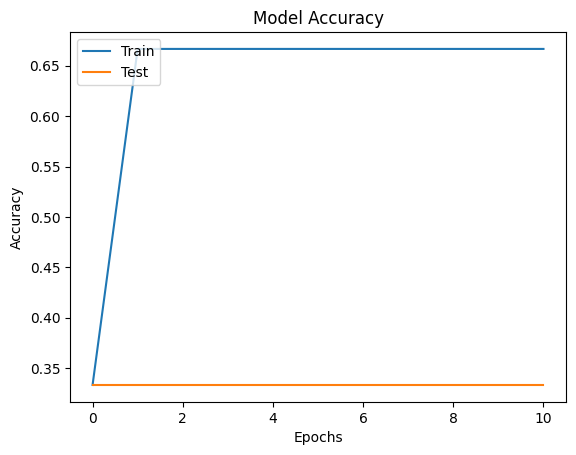

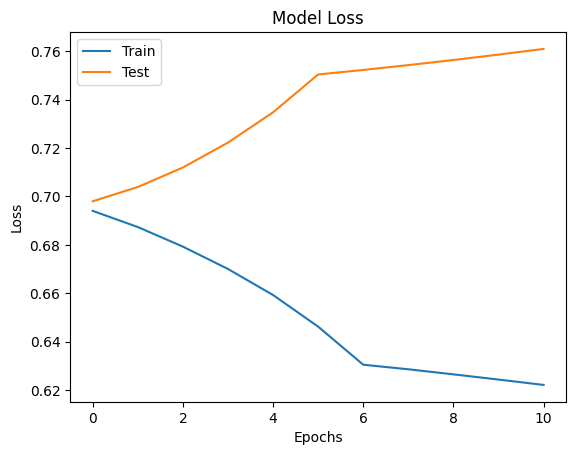

In [128]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])  # Validation metric
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Plot the accuracy and loss
plot_graphs(history_Conv1D, "accuracy")
plot_graphs(history_Conv1D, "loss")


# Testing Model

In [129]:
model_base = tf.keras.models.load_model('best_model.keras')
model_GlobalAveragePooling1D = tf.keras.models.load_model('Model_Basic_GAP.keras')
model_Conv1D = tf.keras.models.load_model('Model_Embedding_Conv1D.keras')

In [147]:
model_base = tf.keras.models.load_model('Basic Model Embeding Layers.h5')
model_GlobalAveragePooling1D = tf.keras.models.load_model('Model Basic + Global Average Pooling.h5')
model_Conv1D = tf.keras.models.load_model('Model_Embedding_Conv1D.h5')

## Testing Base Model

In [ ]:
# Define the tweet
twt = ['i m great man i love my life and this world']
twt = tokenizer.texts_to_sequences(twt)

# Make sure max_length matches the value used during training
max_length = 180  # Adjust if necessary

# Pad the sequence to the correct length
twt = pad_sequences(twt, maxlen=max_length, padding='post', truncating='post')

# Predict the sentiment
prediction_base = model_base.predict(twt)
 
# Print the prediction
if prediction_base[0] >= 0.5:
    print("Non Suicide Post")
else:
    print("Potential Suicide Post")
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Potential Suicide Post


In [153]:
# Define the tweet
twt = ['i m great']
twt = tokenizer.texts_to_sequences(twt)

# Make sure max_length matches the value used during training
max_length = 10_000  # Adjust if necessary

# Pad the sequence to the correct length
twt = pad_sequences(twt, maxlen=max_length, padding='post', truncating='post')

# Predict the sentiment
prediction_base = model_base.predict(twt)
 
# Print the prediction
if prediction_base[0] >= 0.5:
    print("Non Suicide Post")
else:
    print("Potential Suicide Post")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Potential Suicide Post


## Testing Basic + Global Average Pooling

In [131]:
# Testing Basic + Global Average Pooling
prediction_Globalave = model_GlobalAveragePooling1D.predict(twt)

# Print the prediction
if(np.argmax(prediction_Globalave) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction_Globalave) == 1):
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Potential Suicide Post


## Testing Embeding + Conv1D

In [132]:
# Testing Embeding + Conv1D
prediction_EmbedCov1D = model_Conv1D.predict(twt)

# Print the prediction
if(np.argmax(prediction_EmbedCov1D) == 0):
    print("Potential Suicide Post")
elif (np.argmax(prediction_EmbedCov1D) == 1):
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Potential Suicide Post


# Comparation Model

In [133]:
# Ensure that the 'testing_padded' input is the correct shape
print(f"Shape of testing_padded: {testing_padded.shape}")  # Should print (num_samples, 200)

# Check the first few labels
print(f"First few testing labels: {testing_labels[:5]}")  # Ensure these are properly formatted

# If you're loading pre-trained models, ensure they're compiled first:
def compile_model_if_needed(model):
    if not model.optimizer:  # If the model does not have an optimizer, it is not compiled
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Compile models if needed
model_base = compile_model_if_needed(model_base)
model_GlobalAveragePooling1D = compile_model_if_needed(model_GlobalAveragePooling1D)
model_Conv1D = compile_model_if_needed(model_Conv1D)

# Evaluate each model
results_base = model_base.evaluate(testing_padded, testing_labels)
results_GlobalAveragePooling1D = model_GlobalAveragePooling1D.evaluate(testing_padded, testing_labels)
results_Conv1D = model_Conv1D.evaluate(testing_padded, testing_labels)

# Compare model accuracy
import pandas as pd
results = pd.DataFrame({
    'Model': ['Base Model', 'Base + Global Average Pooling', 'Base + CNN'],
    'Accuracy Score': [results_base[1], results_GlobalAveragePooling1D[1], results_Conv1D[1]]
})

# Sort the models by Accuracy Score in descending order
result_df = results.sort_values(by='Accuracy Score', ascending=False)

# Set the 'Model' column as the index
result_df = result_df.set_index('Model')

# Display the result
print(result_df)


Shape of testing_padded: (3, 200)
First few testing labels: [0 1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3333 - loss: 0.9826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6667 - loss: 0.6674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.3333 - loss: 0.6980
                               Accuracy Score
Model                                        
Base + Global Average Pooling        0.666667
Base Model                           0.333333
Base + CNN                           0.333333


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
                                                Text Actual Label Base Model  \
0                            I want to enjoy my life     Negative   Positive   
1                           I want to end everything     Positive   Positive   
2                       I feel so tired of this life     Negative   Negative   
3                I'm excited about tomorrow's plans!     Positive   Negative   
4            Nobody cares about me, I feel worthless     Negative   Negative   
5                 Life is amazing, I feel so blessed     Positive   Positive   
6            Sometimes I just feel like disappearing     Negative   Negative   
7  This is the best day ever, so many good things...     Positive   Positive   
8                              I want to end my life     Negative   Positive   
9                 Everything feels hopeless and dark     Negative   Positive   

  Glo

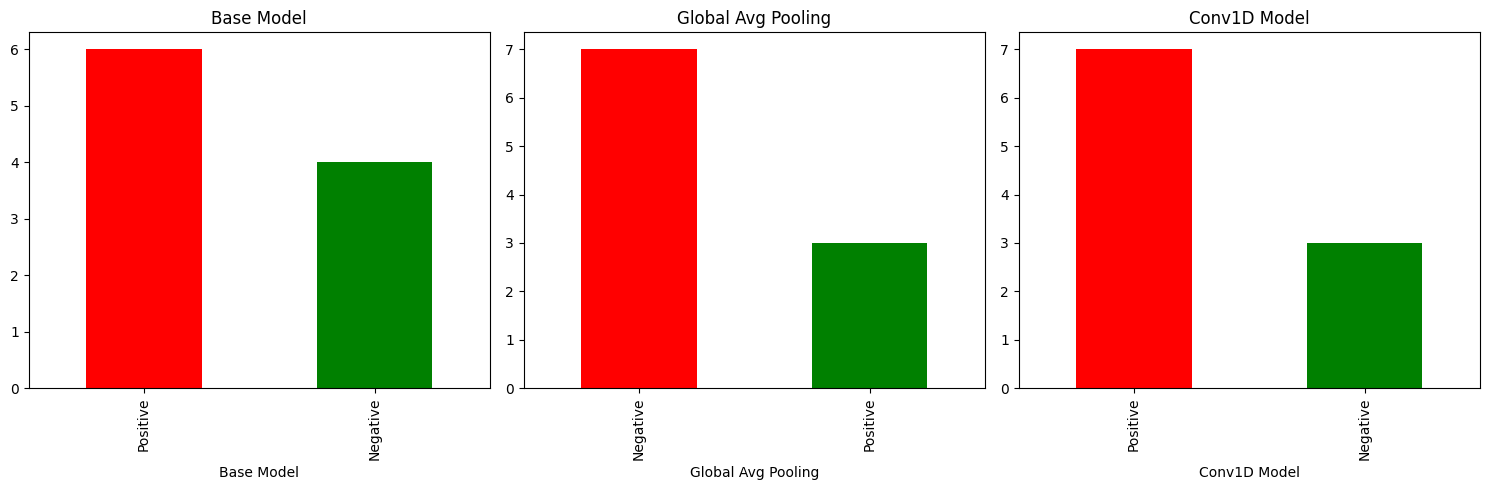

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Load the trained models
# model_base = load_model('best_model.keras')
# model_GlobalAveragePooling1D = load_model('Model_Basic_GAP.keras')
# model_Conv1D = load_model('Model_Embedding_Conv1D.keras')

# Load the trained models
model_base = load_model('Basic Model Embeding Layers.h5')
model_GlobalAveragePooling1D = load_model('Model Basic + Global Average Pooling.h5')
model_Conv1D = load_model('Model_Embedding_Conv1D.h5')

# Updated training text data
training_texts = [
    "Ex wife threaten suicide. Rec left wife good. Cheat twice, lie much, decide refuse go back. Day ago began threaten suicide tirelessly. Spent past day talking, keep hesitating. Want believe come back. Know lot people threaten in order get way. Happen really suppose handle death hand? Still love wife, cannot deal get cheat constantly. Feel insecure, worry today may be day. Hope much happen.",
    "Weird get affect compliment come someone know irl. Feel really good internet stranger.",
    "Final almost never hear bad year ever. Swear fuck god annoy.",
    "Need help. Just help. I'm crying hard."
]

# Updated testing texts
testing_texts = [
    "I want to enjoy my life",  # Positive sentiment example
    "I want to end everything",  # Negative sentiment example
    "I feel so tired of this life",  # Negative sentiment example
    "I'm excited about tomorrow's plans!",  # Positive sentiment example
    "Nobody cares about me, I feel worthless",  # Negative sentiment example
    "Life is amazing, I feel so blessed",  # Positive sentiment example
    "Sometimes I just feel like disappearing",  # Negative sentiment example
    "This is the best day ever, so many good things happened!",  # Positive sentiment example
    "I want to end my life",  # Negative sentiment example
    "Everything feels hopeless and dark",  # Negative sentiment example
]

# Tokenizer setup
vocab_size = 10_000  # Adjust as needed
max_length = 10_000    # Maximum length for padding
embedding_dim = 16 # Embedding dimension

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(training_texts + testing_texts)  # Fit on both train and test texts

# Convert text to sequences
training_sequences = tokenizer.texts_to_sequences(training_texts)
testing_sequences = tokenizer.texts_to_sequences(testing_texts)

# Pad sequences to ensure equal input length
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating='post')
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays (replace with actual labels)
training_labels = np.array([1, 0, 1, 0])  # Example labels
testing_labels = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0])  # Example labels for binary classification

# Predict using all three models
predictions_base = model_base.predict(testing_padded)
predictions_gap = model_GlobalAveragePooling1D.predict(testing_padded)
predictions_cnn = model_Conv1D.predict(testing_padded)

# Convert probabilities to binary labels for binary classification
binary_labels_base = (predictions_base > 0.5).astype("int32").flatten()
binary_labels_gap = (predictions_gap > 0.5).astype("int32").flatten()
binary_labels_cnn = (predictions_cnn > 0.5).astype("int32").flatten()

# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Text': testing_texts,
    'Actual Label': ['Positive' if lbl == 1 else 'Negative' for lbl in testing_labels],
    'Base Model': ['Positive' if lbl == 1 else 'Negative' for lbl in binary_labels_base],
    'Global Avg Pooling': ['Positive' if lbl == 1 else 'Negative' for lbl in binary_labels_gap],
    'Conv1D Model': ['Positive' if lbl == 1 else 'Negative' for lbl in binary_labels_cnn],
})

# Print the results
print(results_df)

# Optionally, plot prediction distributions for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

results_df['Base Model'].value_counts().plot(kind='bar', color=['red', 'green'], ax=axes[0], title='Base Model')
results_df['Global Avg Pooling'].value_counts().plot(kind='bar', color=['red', 'green'], ax=axes[1], title='Global Avg Pooling')
results_df['Conv1D Model'].value_counts().plot(kind='bar', color=['red', 'green'], ax=axes[2], title='Conv1D Model')

plt.tight_layout()
plt.show()
